In [ ]:
print("Training notebook")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/Inception_time/InceptionTime/

/content/gdrive/MyDrive/Inception_time/InceptionTime


In [ ]:
!pwd

/content/gdrive/MyDrive/Inception_time/InceptionTime


In [ ]:
import sys
sys.path.append("./")
from utils import utils

In [ ]:
from main import *

In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 6.8MB/s 


In [ ]:
!python3 main.py -i /content/gdrive/MyDrive/Inception_time/InceptionTime/archives/UCR_TS_Archive_2015 -d /content/gdrive/MyDrive/Inception_time/InceptionTime/MixUp_results/20210712_test -a GROUPED_TSC -p 5 --mixup True -g True

Traceback (most recent call last):
  File "main.py", line 25, in <module>
    import classifiers 
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 963, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 906, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1280, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1252, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1364, in find_spec
  File "<frozen importlib._bootstrap_external>", line 81, in _path_stat
KeyboardInterrupt


In [ ]:
for i in range(17):
  !python3 main.py -d /content/gdrive/MyDrive/Inception_time/InceptionTime/MixUp_results/20210712_test -a GROUPED_TSC -p i --mixup True -g True

(array([  0,   0,   1, ..., 686, 687, 687]),
 array([0, 1, 0, ..., 1, 0, 1]),
 array([0, 0, 0, ..., 0, 0, 0]))

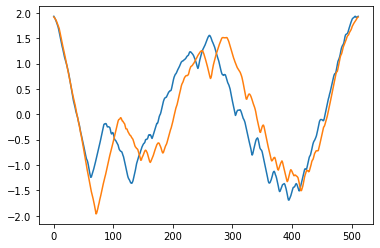

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train[1])

In [ ]:
print(x_train[0][path][600])
print(x_train[1][path][600])

tensor([[-0.6447],
        [-0.2064]], dtype=torch.float64)
tensor([[-0.9064],
        [-0.6719]], dtype=torch.float64)


# Mix up part

In [ ]:
device = torch.device("cpu")

def prepare_data(datasets_dict, dataset_name):
    x_train = datasets_dict[dataset_name][0]
    y_train = datasets_dict[dataset_name][1]
    x_test = datasets_dict[dataset_name][2]
    y_test = datasets_dict[dataset_name][3]

    nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

    # make the min to zero of labels
    y_train, y_test = transform_labels(y_train, y_test)

    # save orignal y because later we will use binary
    y_true = y_test.astype(np.int64)
    y_true_train = y_train.astype(np.int64)
    # transform the labels from integers to one hot vectors
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        x_train = np.array(x_train)
        x_test = np.array(x_test)
    
    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    y_true = torch.from_numpy(y_true)

    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_true, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size= 64, shuffle=True, num_workers= 0)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers= 0)
   
    return train_dataloader, test_dataloader, nb_classes, y_true, enc

use_cuda = torch.cuda.is_available()
def mixup_data(x, y, alpha=0.4, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    
    return mixed_x, mixed_y

In [ ]:
def jitter(x, sigma=0.08):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)


In [ ]:
archive_name = 'TSC'
datasets_dict = read_all_datasets(root_dir, archive_name)
DATASET_NAMES = ['Herring']
for dataset_name in DATASET_NAMES:
  #x_train, y_train, *_ = prepare_data(datasets_dict, dataset_name)
  train_dataloader, test_dataloader, nb_classes, y_true, enc = prepare_data(datasets_dict, dataset_name)



dataiter = iter(train_dataloader)
ts, labels = dataiter.next()
#x_train.reshape(-1,  x_train[0], x_train[1])
#ts_a = jitter(x_train[0])
ts_a, targets_a = mixup_data(ts, labels, 0.4,use_cuda)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


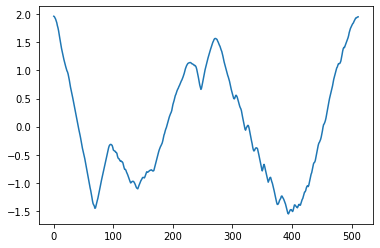

In [ ]:
%matplotlib inline
plt.plot(ts[0], label = 'no_augmentation')
#plt.plot(ts_a[0],label = 'with_augmentation')
#plt.legend()
#plt.savefig('/content/gdrive/MyDrive/Inception_time/InceptionTime/results/distaloriginal.png')